In [1]:
import pandas as pd
import numpy as np
from scalecast.Forecaster import Forecaster
from scalecast.auxmodels import auto_arima
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize':(14,7)})

In [3]:
df = pd.read_excel("Case Prediction Data2.xlsx")
df.head()

<bound method NDFrame.head of         Case Number                                            Subject  \
0            204977                                   Efile Acceptance   
1            204979  Oregon STAT help: Previous Case 203787 Client ...   
2            204980             Data map incorrectly pulling in values   
3            204981  The New Corptax Connect Website is not properl...   
4            204986     LD400 is not reflecting a temporary adjustment   
...             ...                                                ...   
189183       518074  Possible Wrong Calculation for LA Plaquemines ...   
189184       518075  Sch. L and M-2 not populating in Short Period ...   
189185       518076                 Legacy Form 8992 GILTI Calculation   
189186       518077                VA Efile Diagnostics - not due 8/15   
189187       518078                          Request Login Credentials   

              Date Created         Date Closed  Origin Priority  \
0      2017-01

In [4]:
df_comp = df[df["Product"] == "Compliance"]
df_comp.head()

,Case Number,Subject,Date Created,Date Closed,Origin,Priority,Team,Case Type,SLA,Problem Statement,Product,Product Area,Product Category,Product Type,Jurisdiction,Resolution,KB #,KB Title
0,204977,Efile Acceptance,2017-01-02 05:39:00,2017-01-03 09:03:00,Web,Medium,Tax Preparation,Efile,Platinum,We transmitted a Michigan return still have no...,Compliance,Returns / Reports,NaN,NaN,US.MI,Answer exists KB,041324813494120,How to understand the Transmission Monitor
4,204986,LD400 is not reflecting a temporary adjustment,2017-01-03 07:17:00,2017-01-05 08:21:00,E-mail,Medium,Tax Preparation,Problem / Error,Platinum,LD400 is not reflecting a temporary adjustment,Compliance,Returns / Reports,NaN,NaN,US,Answer exists KB,041622907012748,Adjustments do not flow to LD400 workpaper and...
6,204992,Form 2220 Line 19 dates.,2017-01-03 07:36:00,2017-01-10 09:16:00,Web,Medium,Tax Preparation,Problem / Error,Platinum,Form 2220 Line 19 dates are repeating. This is...,Compliance,Amounts,NaN,NaN,US,Answer exists KB,041335414275440,IRS e-Services and Business MeF Maintenance in...
8,204997,Corptax Upgrade File,2017-01-03 08:15:00,2017-01-03 11:36:00,Web,Medium,IT / Systems,Question / How To,Silver,provide MSI Files,Compliance,Install / Rollover,Provide Corptax Client MSI Files,NaN,NaN,Answer exists KB,NaN,NaN
10,205001,Share the MSI files for Corptax 2016.2,2017-01-03 08:24:00,2017-01-03 11:30:00,Web,Medium,IT / Systems,Question / How To,Gold,provide MSI Files,Compliance,Install / Rollover,Provide Corptax Client MSI Files,NaN,NaN,Answer exists KB,NaN,NaN


In [5]:
#dfc = df[df.Product == "Compliance"]
df_comp['Date Created'] = df_comp['Date Created'].dt.date
df_comp['Date Closed'] = df_comp['Date Closed'].dt.date
df_comp['Date'] = pd.to_datetime(df_comp['Date Created'], errors='coerce')
dfc = df_comp

In [6]:
# Adding a new column which will have the number of tickets per day
newdf = dfc[["Date","Case Number"]]
newdf.drop_duplicates(inplace=True)
newdf['Date'] = pd.to_datetime(newdf['Date'])
newdf = pd.DataFrame(newdf.groupby([newdf["Date"].dt.date]).count()["Case Number"])
newdf = newdf.reset_index()
newdf.index = newdf.Date
newdf['Date'] = pd.to_datetime(newdf['Date'], errors='coerce')
newdf = newdf.asfreq('D')
newdf = newdf.groupby(pd.Grouper(freq="M")).sum()
newdf

,Case Number
Date,
2017-01-31,1066.0
2017-02-28,1300.0
2017-03-31,2092.0
2017-04-30,1247.0
2017-05-31,1407.0
...,...
2022-04-30,914.0
2022-05-31,777.0
2022-06-30,952.0


In [8]:
newdf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 68 entries, 2017-01-31 to 2022-08-31
Freq: M
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Case Number  68 non-null     float64
dtypes: float64(1)
memory usage: 1.1 KB


In [25]:
f = Forecaster(y=newdf['Case Number'],current_dates=newdf.index)
f

Forecaster(
    DateStartActuals=2017-01-31T00:00:00.000000000
    DateEndActuals=2022-08-31T00:00:00.000000000
    Freq=M
    N_actuals=68
    ForecastLength=0
    Xvars=[]
    Differenced=0
    TestLength=1
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    BootstrapSamples=100
    CurrentEstimator=None
    GridsFile=Grids
)

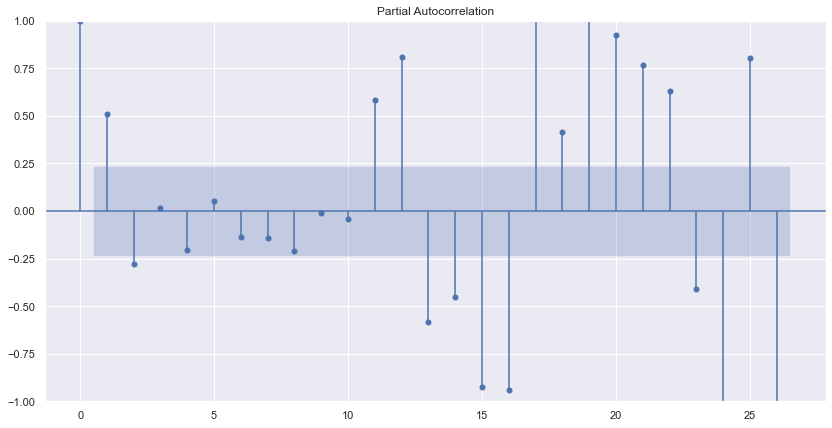

In [26]:
f.plot_pacf(lags=26)
plt.show()

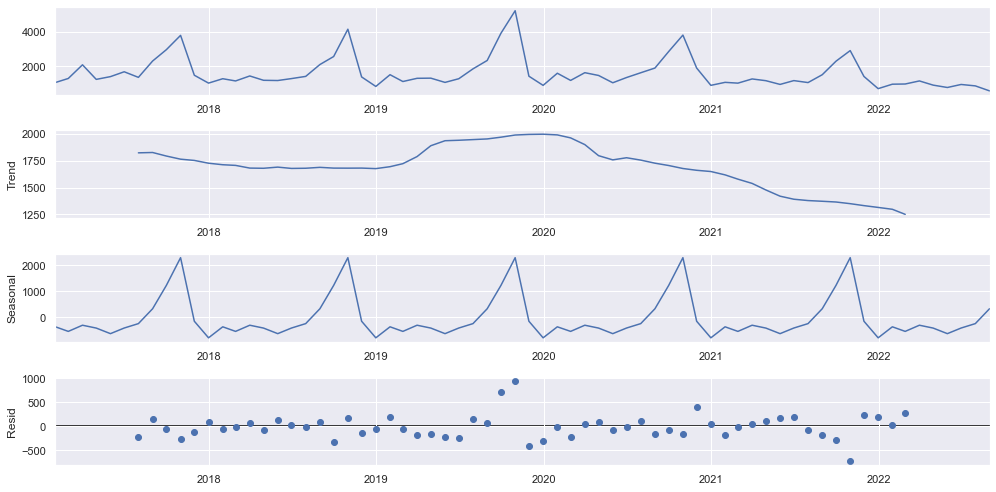

In [27]:
f.seasonal_decompose().plot()
plt.show()

In [28]:
stat, pval, _, _, _, _ = f.adf_test(full_res=True)
stat

1.0148828917510513

In [29]:
pval

0.9944205244966136

In [30]:
f.set_test_length(24)       
f.generate_future_dates(12)
f.set_estimator('lstm')

2/2 [==============================] - 0s 2ms/step


<AxesSubplot:xlabel='Date', ylabel='Values'>

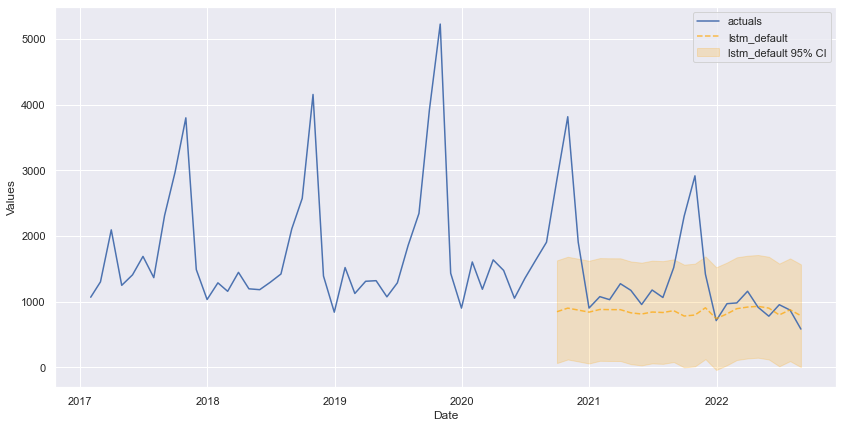

In [31]:
f.manual_forecast(call_me='lstm_default')
f.plot_test_set(ci=True)

2/2 [==============================] - 0s 4ms/step


<AxesSubplot:xlabel='Date', ylabel='Values'>

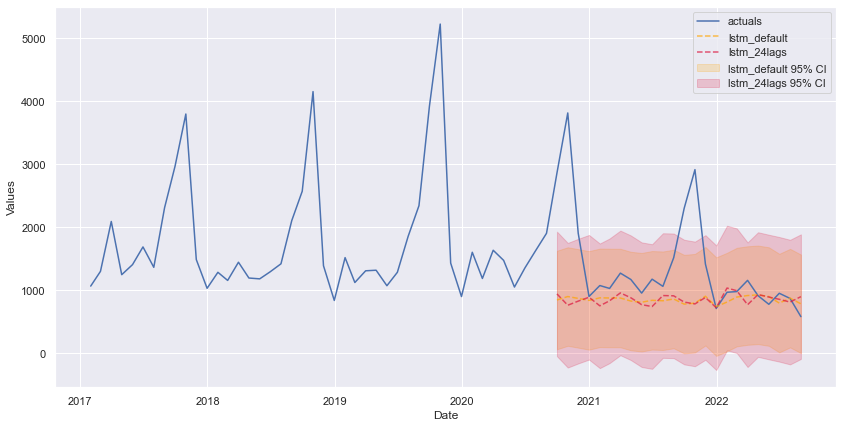

In [34]:
f.manual_forecast(call_me='lstm_24lags',lags=12)
f.plot_test_set(ci=True)

Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.2241 - val_loss: 0.2225
Epoch 2/10
1/1 [==============================] - 0s 44ms/step - loss: 0.2221 - val_loss: 0.2207
Epoch 3/10
1/1 [==============================] - 0s 33ms/step - loss: 0.2201 - val_loss: 0.2189
Epoch 4/10
1/1 [==============================] - 0s 31ms/step - loss: 0.2181 - val_loss: 0.2173
Epoch 5/10
1/1 [==============================] - 0s 30ms/step - loss: 0.2162 - val_loss: 0.2156
Epoch 6/10
1/1 [==============================] - 0s 33ms/step - loss: 0.2145 - val_loss: 0.2140
Epoch 7/10
1/1 [==============================] - 0s 39ms/step - loss: 0.2127 - val_loss: 0.2124
Epoch 8/10
1/1 [==============================] - 0s 41ms/step - loss: 0.2110 - val_loss: 0.2108
Epoch 9/10
1/1 [==============================] - 0s 36ms/step - loss: 0.2094 - val_loss: 0.2092
Epoch 10/10
1/1 [==============================] - 0s 365ms/step
Epoch 1/10
2/2 [==============================] - 3s 816ms/step 

<AxesSubplot:xlabel='Date', ylabel='Values'>

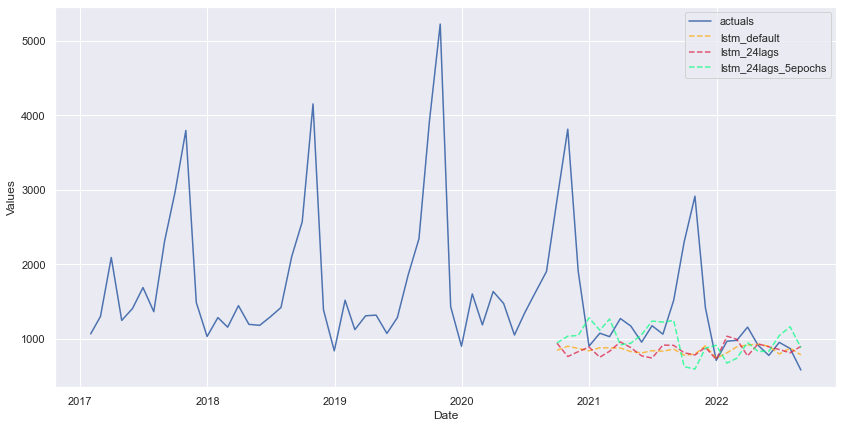

In [37]:
f.manual_forecast(call_me='lstm_24lags_5epochs',
                  lags=12,
                  epochs=10,
                  validation_split=.2,
                  shuffle=True)
f.plot_test_set(ci=False)

Epoch 1/25
1/1 [==============================] - 5s 5s/step - loss: 0.2274 - val_loss: 0.2209
Epoch 2/25
1/1 [==============================] - 0s 48ms/step - loss: 0.2252 - val_loss: 0.2188
Epoch 3/25
1/1 [==============================] - 0s 39ms/step - loss: 0.2231 - val_loss: 0.2167
Epoch 4/25
1/1 [==============================] - 0s 43ms/step - loss: 0.2210 - val_loss: 0.2147
Epoch 5/25
1/1 [==============================] - 0s 36ms/step - loss: 0.2189 - val_loss: 0.2126
Epoch 6/25
1/1 [==============================] - 0s 36ms/step - loss: 0.2168 - val_loss: 0.2106
Epoch 7/25
1/1 [==============================] - 0s 38ms/step - loss: 0.2145 - val_loss: 0.2084
Epoch 8/25
1/1 [==============================] - 0s 43ms/step - loss: 0.2122 - val_loss: 0.2061
Epoch 9/25
1/1 [==============================] - 0s 52ms/step - loss: 0.2098 - val_loss: 0.2037
Epoch 10/25
1/1 [==============================] - 0s 47ms/step - loss: 0.2074 - val_loss: 0.2013
Epoch 11/25
1/1 [==============

<AxesSubplot:xlabel='Date', ylabel='Values'>

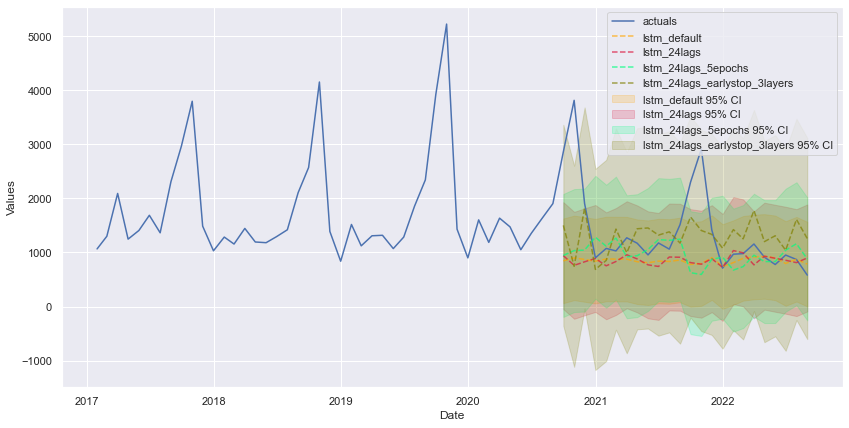

In [38]:
from tensorflow.keras.callbacks import EarlyStopping
f.manual_forecast(call_me='lstm_24lags_earlystop_3layers',
                  lags=12,
                  epochs=25,
                  validation_split=.2,
                  shuffle=True,
                  callbacks=EarlyStopping(monitor='val_loss',
                                          patience=5),
                  lstm_layer_sizes=(16,16,16),
                  dropout=(0,0,0))
f.plot_test_set(ci=True)

Epoch 1/15
1/1 [==============================] - 8s 8s/step - loss: 0.2276 - val_loss: 0.2189
Epoch 2/15
1/1 [==============================] - 0s 46ms/step - loss: 0.2222 - val_loss: 0.2136
Epoch 3/15
1/1 [==============================] - 0s 44ms/step - loss: 0.2163 - val_loss: 0.2075
Epoch 4/15
1/1 [==============================] - 0s 43ms/step - loss: 0.2090 - val_loss: 0.1997
Epoch 5/15
1/1 [==============================] - 0s 40ms/step - loss: 0.1995 - val_loss: 0.1917
Epoch 6/15
1/1 [==============================] - 0s 43ms/step - loss: 0.1889 - val_loss: 0.1821
Epoch 7/15
1/1 [==============================] - 0s 40ms/step - loss: 0.1768 - val_loss: 0.1763
Epoch 8/15
1/1 [==============================] - 0s 57ms/step - loss: 0.1689 - val_loss: 0.1754
Epoch 9/15
1/1 [==============================] - 0s 68ms/step - loss: 0.1647 - val_loss: 0.1776
Epoch 10/15
1/1 [==============================] - 0s 63ms/step - loss: 0.1620 - val_loss: 0.1780
Epoch 11/15
1/1 [==============

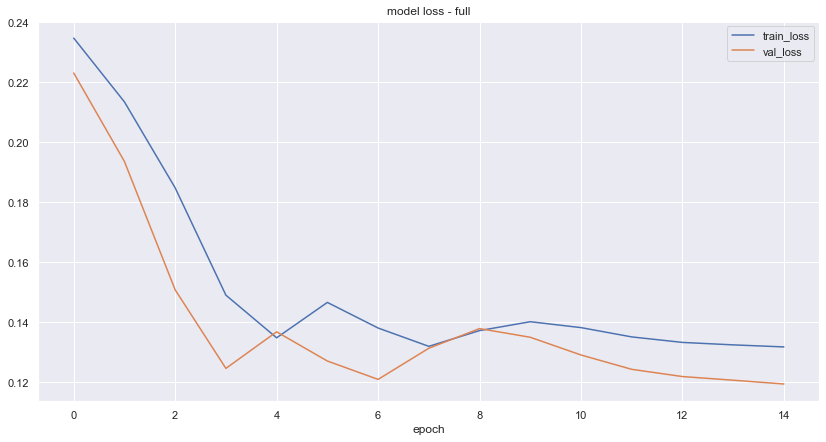

2/2 [==============================] - 0s 9ms/step


<AxesSubplot:xlabel='Date', ylabel='Values'>

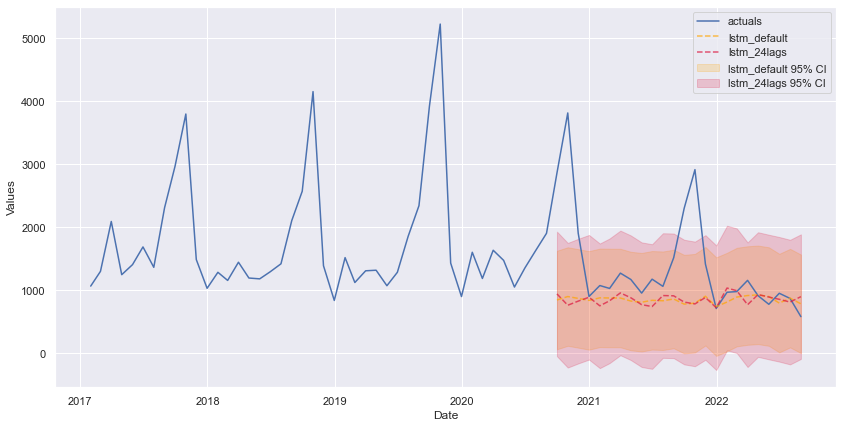

In [40]:
f.manual_forecast(call_me='lstm_best',
                  lags=12,
                  batch_size=32,
                  epochs=15,
                  validation_split=.2,
                  shuffle=True,
                  activation='tanh',
                  optimizer='Adam',
                  learning_rate=0.001,
                  lstm_layer_sizes=(72,)*4,
                  dropout=(0,)*4,
                  plot_loss=True)
f.plot_test_set(order_by='LevelTestSetMAPE',models='top_2',ci=True)

# MLR Forecasting

In [44]:
f.set_estimator('mlr') # 1. choose the mlr estimator
f.add_ar_terms(12) # 2. add regressors (24 lagged terms)
f.add_seasonal_regressors('month','quarter',dummy=True) # 2.
f.add_seasonal_regressors('year') # 2.
# f.add_time_trend() # 2.
# f.diff() # 3. difference non-stationary data

<AxesSubplot:xlabel='Date', ylabel='Values'>

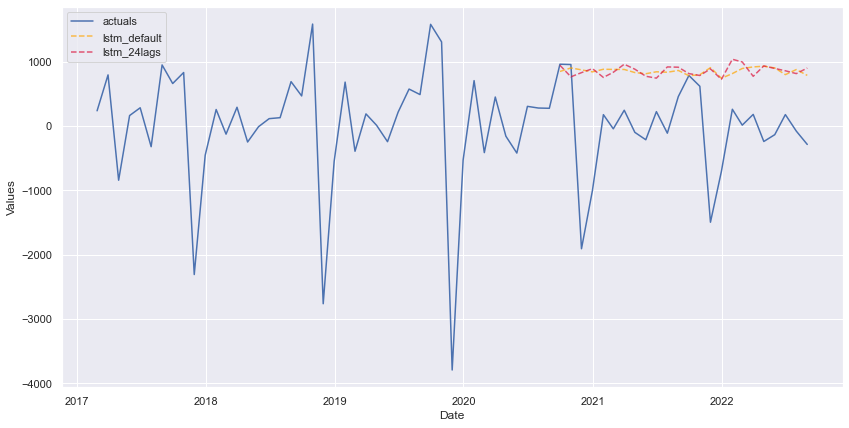

In [45]:
f.manual_forecast()
f.plot_test_set(order_by='LevelTestSetMAPE',models='top_2')

<AxesSubplot:xlabel='Date', ylabel='Values'>

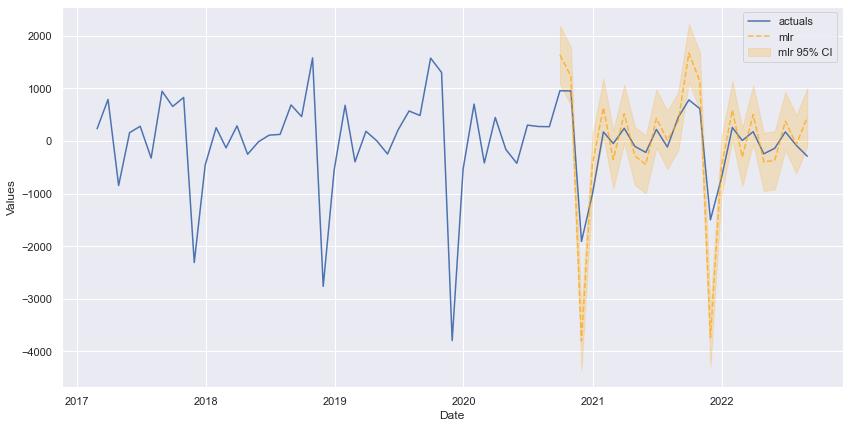

In [46]:
f.plot_test_set(models='mlr',ci=True)

<AxesSubplot:xlabel='Date', ylabel='Values'>

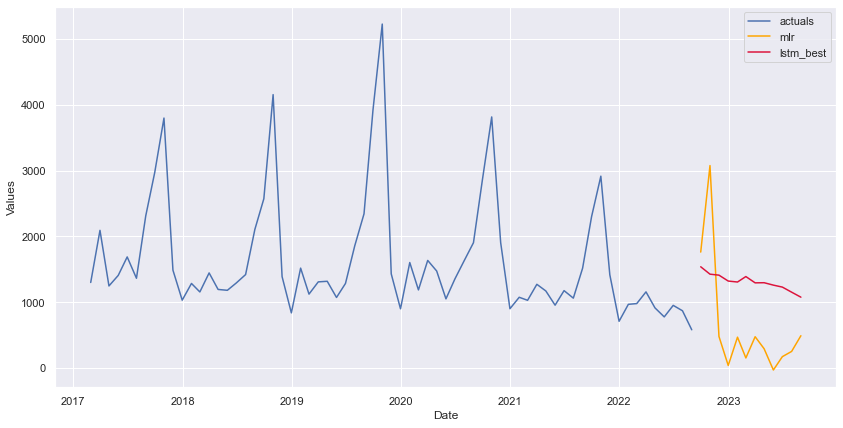

In [47]:
f.plot(models=['mlr','lstm_best'],
       order_by='LevelTestSetMAPE',
       level=True)

In [48]:
f.export('model_summaries',determine_best_by='LevelTestSetMAPE')[
    ['ModelNickname',
     'LevelTestSetMAPE',
     'LevelTestSetRMSE',
     'LevelTestSetR2',
     'best_model']
]

,ModelNickname,LevelTestSetMAPE,LevelTestSetRMSE,LevelTestSetR2,best_model
0,lstm_default,0.293331,953.702072,-0.461231,True
1,lstm_24lags,0.300234,966.713176,-0.501373,False
2,lstm_24lags_5epochs,0.313851,947.525959,-0.442367,False
3,mlr,0.378650,590.953513,0.438952,False
4,lstm_24lags_earlystop_3layers,0.397987,843.197749,-0.142227,False
5,lstm_best,0.498829,791.241843,-0.005801,False


In [11]:
f.generate_future_dates(12)
f.set_test_length(.2)
f.set_estimator('arima')
f.manual_forecast(call_me='arima1')

# Auto-ARIMA Approach

In [12]:
auto_arima(
    f,
    start_P=1,
    start_q=1,
    max_p=6,
    max_q=6,
    m=12,
    seasonal=True,
    max_P=4, 
    max_D=4,
    max_Q=4,
    max_d=4,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,
    information_criterion="aic",
    alpha=0.05,
    scoring='mse',
    call_me='arima3',
)

Performing stepwise search to minimize aic
 ARIMA(2,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=629.146, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=579.873, Time=0.08 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=627.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=616.511, Time=0.07 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=596.404, Time=0.19 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=588.964, Time=0.06 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=580.900, Time=0.14 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(2,1,1)(1,0,0)[12] intercept   : AIC=inf, Time=0.29 sec

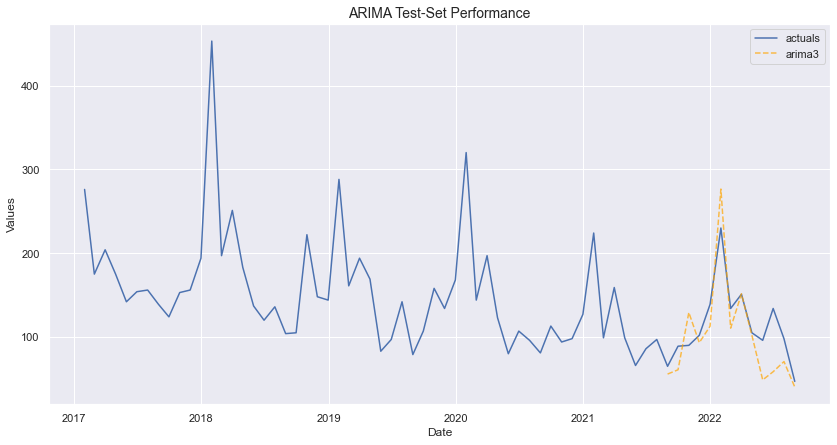

In [13]:
f.plot_test_set(ci=False,models='arima3')
plt.title('ARIMA Test-Set Performance',size=14)
plt.show()

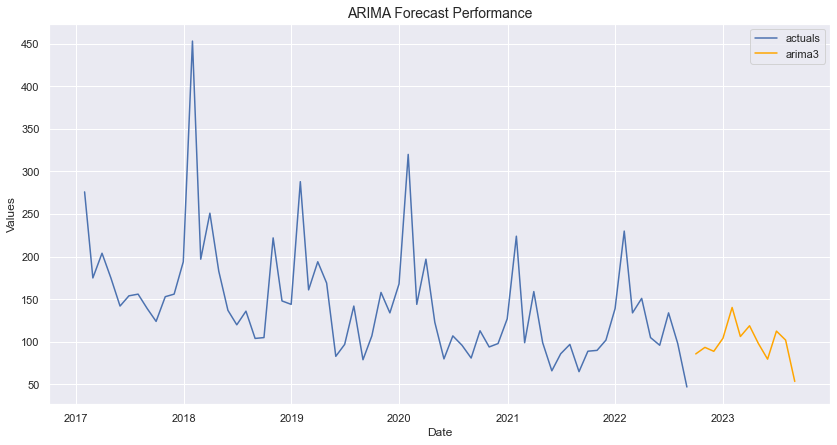

In [14]:
f.plot(ci=False,models='arima3')
plt.title('ARIMA Forecast Performance',size=14)
plt.show()

In [15]:
pd.options.display.max_colwidth = 100
results = f.export(to_excel=True,
                   excel_name='arima_results.xlsx',
                   determine_best_by='TestSetMAPE')

In [16]:
results["test_set_predictions"]

,DATE,actual,arima3,arima1
55,2021-08-31,65.0,55.750675,153.418179
56,2021-09-30,89.0,60.856285,153.418179
57,2021-10-31,90.0,129.185294,153.418179
58,2021-11-30,102.0,93.212717,153.418179
59,2021-12-31,139.0,112.884538,153.418179
60,2022-01-31,230.0,276.489085,153.418179
61,2022-02-28,134.0,110.514659,153.418179
62,2022-03-31,151.0,151.518475,153.418179
63,2022-04-30,105.0,102.004790,153.418179
64,2022-05-31,96.0,48.783197,153.418179


In [17]:
results["all_fcsts"]

,DATE,arima1,arima3
0,2022-09-30,145.852937,85.838542
1,2022-10-31,145.852937,93.508110
2,2022-11-30,145.852937,88.895985
3,2022-12-31,145.852937,104.207094
4,2023-01-31,145.852937,140.332897
5,2023-02-28,145.852937,106.256850
6,2023-03-31,145.852937,118.861035
7,2023-04-30,145.852937,97.988433
8,2023-05-31,145.852937,79.690987
9,2023-06-30,145.852937,112.597160


# =============================================================

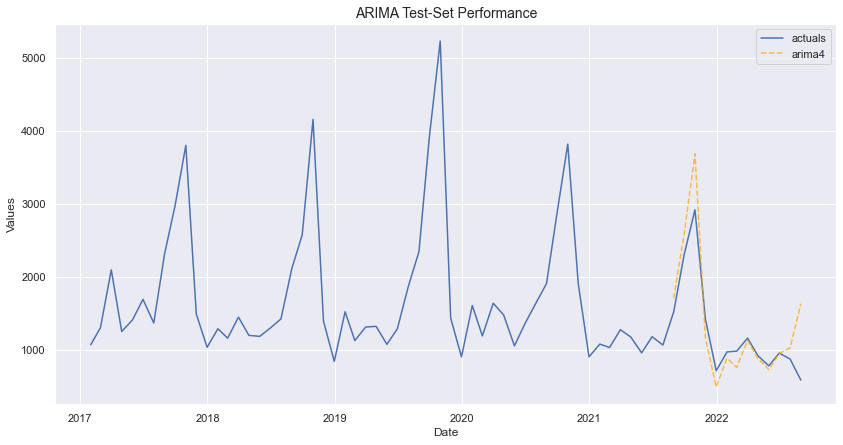

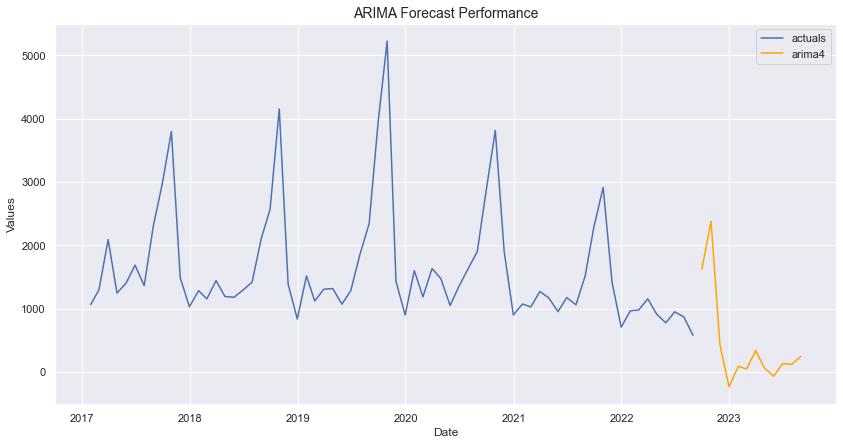

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   68
Model:             ARIMA(1, 1, 0)x(1, 1, [1], 12)   Log Likelihood                -408.452
Date:                            Fri, 26 Aug 2022   AIC                            824.904
Time:                                    16:51:44   BIC                            832.933
Sample:                                         0   HQIC                           828.009
                                             - 68                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2737      0.188     -1.454      0.146      -0.643       0.095
ar.S.L12       0.3900      0.330      1.182      0.237      -0.257       1.037
ma.S.L12      -0.9902     10.486     -0.094      0.925     -21.541      19.561
sigma2      1.333e+05   1.36e+06      0.098      0.922   -2.53e+06     2.8e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.61   Jarque-Bera (JB):                12.44
Prob(Q):                              0.44   Prob(JB):                         0.00
Heteroskedasticity (H):               0.75   Skew:                             0.46
Prob(H) (two-sided):                  0.54   Kurtosis:                         5.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [215]:
f.set_validation_length(12)
grid = {
    'order':[(1,1,1),(1,1,0),(0,1,1)],
    'seasonal_order':[(2,1,1,12),(1,1,1,12),(2,1,0,12),(0,1,0,12)]
}

f.ingest_grid(grid)
f.tune()
f.auto_forecast(call_me='arima4')

f.plot_test_set(ci=False,models='arima4')
plt.title('ARIMA Test-Set Performance',size=14)
plt.show()

f.plot(ci=False,models='arima4')
plt.title('ARIMA Forecast Performance',size=14)
plt.show()

f.regr.summary()

In [216]:
pd.options.display.max_colwidth = 100
results = f.export(to_excel=True,
                   excel_name='arima_results.xlsx',
                   determine_best_by='TestSetMAPE')

In [217]:
results["test_set_predictions"]
results["all_fcsts"]

,DATE,actual,arima4,arima2,arima3,arima1
55,2021-08-31,1517.0,1702.625656,1864.583179,1889.436807,1711.981871
56,2021-09-30,2300.0,2582.738084,2511.477406,3386.024467,1711.981871
57,2021-10-31,2915.0,3682.114872,3633.539862,4377.117595,1711.981871
58,2021-11-30,1417.0,1161.872889,1299.856642,1718.021872,1711.981871
59,2021-12-31,710.0,487.171588,655.024484,895.707528,1711.981871
60,2022-01-31,968.0,879.611172,972.754895,1298.928629,1711.981871
61,2022-02-28,979.0,756.989674,883.125150,1094.670314,1711.981871
62,2022-03-31,1157.0,1125.841442,1230.653855,1424.927616,1711.981871
63,2022-04-30,914.0,874.646439,942.788336,1298.279566,1711.981871
64,2022-05-31,777.0,725.686055,904.774353,995.411103,1711.981871


In [218]:
results["all_fcsts"]

,DATE,arima1,arima2,arima3,arima4
0,2022-09-30,1620.819437,1932.067910,1889.421139,1625.693075
1,2022-10-31,1620.819437,2981.945128,2733.757837,2382.789529
2,2022-11-30,1620.819437,791.024890,1294.865269,430.849719
3,2022-12-31,1620.819437,236.550741,619.085756,-235.628436
4,2023-01-31,1620.819437,619.801875,909.955076,90.661312
5,2023-02-28,1620.819437,525.169692,940.730385,48.910194
6,2023-03-31,1620.819437,854.534913,1144.475346,338.270787
7,2023-04-30,1620.819437,549.847584,931.090655,62.277341
8,2023-05-31,1620.819437,428.037525,790.075445,-64.500533
9,2023-06-30,1620.819437,631.389797,975.325472,133.178434
